<class 'numpy.ndarray'>


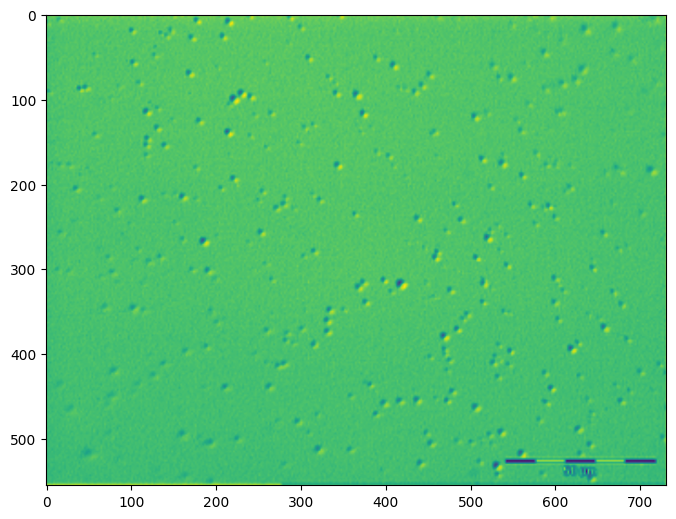

In [2]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2
#from skimage.io import imread, imshow
mpl.rcParams['figure.figsize'] = [8,8]

img = cv2.imread('C:/Users/kelle/Paleo/Thesis/Pictures/art_etch_a.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
print(type(img))


[  0 255]


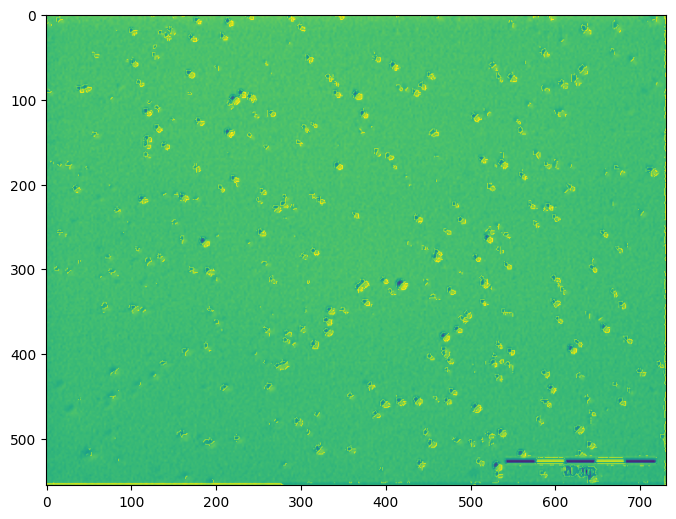

In [63]:
'get a way to adjust the edge thresholds based on the image contrast?'
# 
low_threshold = 60
high_threshold = 70
edges = cv2.Canny(img, low_threshold, high_threshold)
# plt.subplot(121), plt.imshow(img)
# plt.title('Original image'), plt.xticks([]), plt.yticks([])
# plt.subplot(122), plt.imshow(edges)
# plt.title('Edge image'), plt.xticks([]), plt.yticks([])
# plt.show()
cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
overlay = cv2.addWeighted(img, 1, edges, 0.2, 0.0)
plt.imshow(overlay)
print(np.unique(edges))
np.savetxt('edges.csv', edges, delimiter=',')


159


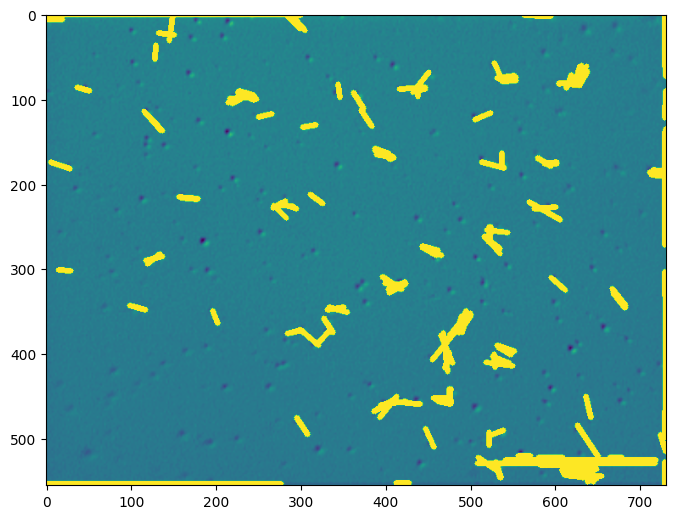

In [64]:
rho = 1
theta = np.pi / 180
threshold = 10
min_line_length = 15
max_line_gap = 10
line_image = np.copy(img) * 0

lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
print(len(lines))
for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 5)

lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)

# plt.subplot(131), plt.imshow(img)
# plt.title('Original image'), plt.xticks([]), plt.yticks([])
# plt.subplot(132), plt.imshow(edges)
# plt.title('Edge image'), plt.xticks([]), plt.yticks([])
# plt.subplot(133), plt.imshow(lines_edges)
# plt.title('Edge image'), plt.xticks([]), plt.yticks([])
plt.imshow(lines_edges)

In [49]:
# edge detection with automatic scaling
# https://pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
def auto_canny(image, sigma=0.33):
    # compute median of single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the median
    lower = int(max(0, (1.0-sigma)*v))
    upper = int(min(255, (1.0-sigma)*v))
    edged = cv2.Canny(image, lower, upper)
    return edged

# checks distance btw contours, whether they can be combined
def find_if_close(cnt1, cnt2, threshold=3):
    row1, row2 = cnt1.shape[0], cnt2.shape[0]
    for i in range(row1):
        for j in range(row2):
            dist = np.linalg.norm(cnt1[i]-cnt2[j])
            if abs(dist) < threshold:
                return True
            elif i == row1 - 1 and j == row2 - 1:
                return False


readthese = ['C:/Users/kelle/Paleo/Thesis/Pictures/iona_nolabel.png', 
             'C:/Users/kelle/Paleo/Thesis/Pictures/ionb_nolabel.png',
             'C:/Users/kelle/Paleo/Thesis/Pictures/art_etch_a_nolabel.png']
# readthese = ['C:/Users/kelle/Paleo/Thesis/Pictures/iona_nolabel.png']

# https://stackoverflow.com/questions/45322630/how-to-detect-lines-in-opencv
# loop over images
id = 0
for imagePath in readthese:
    id += 1 
    # load image, convert to grayscale
    image = cv2.imread(imagePath)
    print('preprocessing')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    'Dilation'
    kernel = np.ones((7,7), np.uint8)
    # blurred = cv2.dilate(gray, kernel, iterations=1)
    'opening'
    blurred = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    # blurred = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel)
    'Gaussian blur'
    # blurred = cv2.GaussianBlur(blurred, (3, 3), 0)
    # apply canny edge detection
    print('edge detection')
    auto = auto_canny(blurred, sigma=0.72)
    overlay = cv2.addWeighted(blurred, 1, auto, 0.2, 0.0)
    # plt.imshow(overlay)
    line_image = np.copy(gray)

    # fit an ellipse to the edges
    print('get contours')
    contours, hierarchy = cv2.findContours(auto, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # print(contours[1])

    def combineContours(contours):
        'get average position for each contour for comparison'
        print('calculating contour averages')
        averages = np.zeros((len(contours),2))
        for i in range(len(contours)):
            xsum = 0; ysum = 0
            row = contours[i].shape[0]
            cnt = np.reshape(contours[i], (row, 2))
            for j in range(row):
                xsum += cnt[j][0]
                ysum += cnt[j][1]

            xsum /= row; ysum /= row
            averages[i] = [xsum, ysum]
            # print('contour =', contours[i], ', average is', averages[i])
        # np.savetxt('averages.csv', averages, delimiter=',')
        # print(averages)
        length = len(contours)
        status = np.zeros((length, 1))

        print('checking possible contour combination')
        # unified = []
        for i, cnt1 in enumerate(averages):
            x = i
            if i != length - 1:
                for j, cnt2 in enumerate(averages[i+1:]):
                    x = x+1
                    # dist = find_if_close(cnt1, cnt2)
                    dist = abs(np.linalg.norm(cnt1-cnt2)) <= 12
                    if dist == True:
                        val = min(status[i], status[x])
                        print('combining', cnt1, 'and', cnt2)
                        status[x] = status[i] = val
                        # unified.append
                    else:
                        if status[x] == status[i]:
                            status[x] = i + 1
        print('combining contours')
        unified = []
        maximum =  int(status.max()) + 1
        for i in range(maximum):
            pos = np.where(status == i)[0]
            if pos.size != 0:
                cont = np.vstack(contours[i] for i in pos)
                hull = cv2.convexHull(cont)
                unified.append(cont)
        
        return unified

    'denoise small contours'
    maincnt = [i for i in contours if len(i)>=12]

    combining = True
    if combining:
        unified = combineContours(maincnt)
    else:
        unified = maincnt

    denoised = [i for i in unified if cv2.contourArea(i) >= 3]
    shape = [cv2.convexHull(cnt) for cnt in denoised]

    print('drawing contours')
    cv2.drawContours(line_image, shape, -1, (0,255,0), 1)
    'approxpolydp'
    # eps = [0.05*cv2.arcLength(i, True) for i in unified]
    # approx = [cv2.approxPolyDP(i, j, False) for i,j in zip(unified,eps)]
    # cv2.drawContours(line_image, approx, -1,(0,255,0), 1)
    'fit ellipse'
    # approx = [cv2.fitEllipse(i) for i in unified]
    # for i in approx:
    #     cv2.ellipse(line_image, i, (0,255,0),2)
    'bound rectangle'
    # box = [np.int0(cv2.boxPoints(cv2.minAreaRect(i))) for i in unified]
    # cv2.drawContours(line_image, box, -1, (0,255,0),2)

    

    
    # lines_edges = cv2.addWeighted(blurred, 0.8, line_image, 1, 0)
    
    # show image
    cv2.imshow('Edges', np.hstack([gray, blurred, auto, line_image]))
    cv2.waitKey(0)
    saved = np.concatenate((gray, auto, line_image), axis=1)
    cv2.imwrite('out{}.png'.format(id), saved)

    # temp = np.asarray(contours)
    # np.savetxt('contours_{}.csv'.format(imagePath), temp, delimiter=',')
    # print(contours)

preprocessing
edge detection
get contours
calculating contour averages
checking possible contour combination
combining [285.38461538 325.07692308] and [294.10714286 324.53571429]
combining [285.38461538 325.07692308] and [295.32352941 319.41176471]
combining [294.10714286 324.53571429] and [295.32352941 319.41176471]
combining [373.70454545 304.02272727] and [375.23529412 296.11764706]
combining [308.13793103 286.27586207] and [308.64444444 280.88888889]
combining [ 52. 253.] and [ 41.76923077 251.69230769]
combining [ 57.5        236.34615385] and [ 65.60810811 229.27027027]
combining [ 68.83333333 232.33333333] and [ 65.60810811 229.27027027]
combining [251.14035088 222.07017544] and [246.71794872 216.07692308]
combining [226.8125 215.    ] and [222.14285714 205.26190476]
combining [205.76190476 214.04761905] and [208.53333333 207.6       ]
combining [260.         210.41666667] and [268.625 207.5  ]
combining [260.         210.41666667] and [257.42857143 206.71428571]
combining [208.

C:\Users\kelle\AppData\Local\Temp\ipykernel_8164\1784023648.py:100: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  cont = np.vstack(contours[i] for i in pos)


preprocessing
edge detection
get contours
calculating contour averages
checking possible contour combination
combining [170.21052632 334.26315789] and [167.96153846 324.42307692]
combining [ 69.76470588 321.32352941] and [ 69.36842105 309.57894737]
combining [ 69.36842105 309.57894737] and [ 79.23809524 306.23809524]
combining [ 79.23809524 306.23809524] and [ 84.48275862 311.79310345]
combining [ 79.23809524 306.23809524] and [ 90.18181818 303.18181818]
combining [ 84.48275862 311.79310345] and [ 90.18181818 303.18181818]
combining [332.5        275.57142857] and [340.25       272.91666667]
combining [332.5        275.57142857] and [329.28571429 266.92857143]
combining [340.25       272.91666667] and [348.3 269.9]
combining [340.25       272.91666667] and [340.84848485 261.39393939]
combining [348.3 269.9] and [340.84848485 261.39393939]
combining [ 29.         243.91666667] and [ 40.11111111 245.97222222]
combining [345.25714286 241.08571429] and [334.84444444 240.33333333]
combining

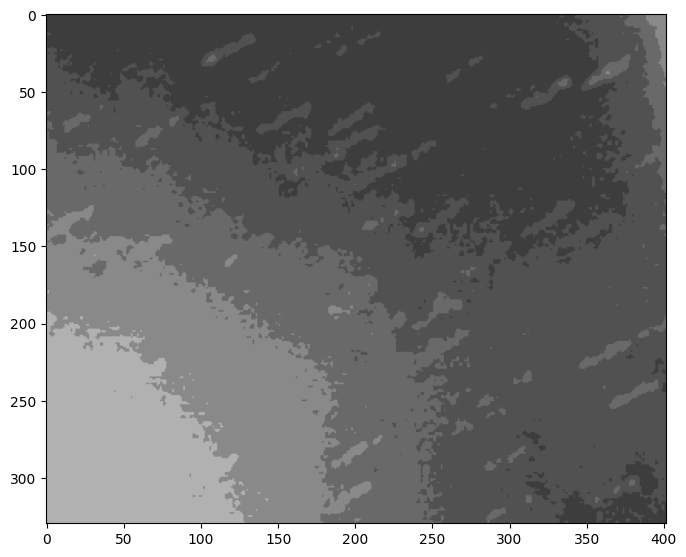

In [3]:
# https://medium.com/towardssingularity/k-means-clustering-for-image-segmentation-using-opencv-in-python-17178ce3d6f3
image = cv2.imread('C:/Users/kelle/Paleo/Thesis/Pictures/iona_nolabel.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pixel_vals = image.reshape((-1,3))
pixel_vals = np.float32(pixel_vals)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
k = 5
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
segmented_image = segmented_data.reshape((image.shape))
plt.imshow(segmented_image)

C:\Users\kelle\AppData\Local\Temp\ipykernel_12600\3449253187.py:40: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  cont = np.vstack(contours[i] for i in pos)


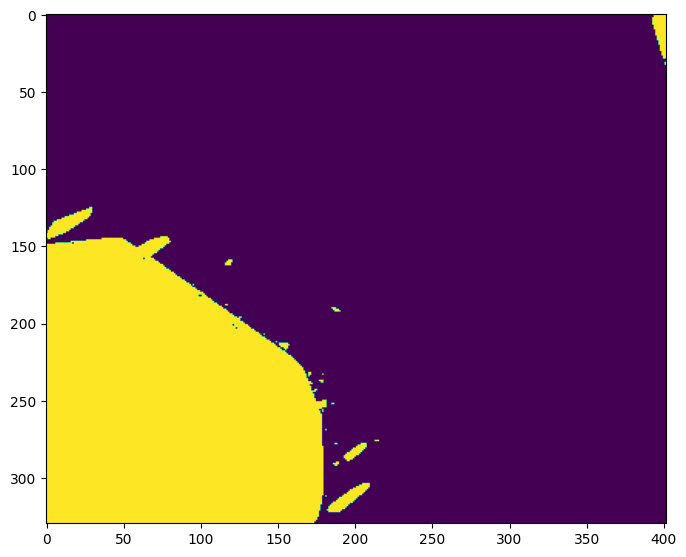

In [8]:
# trying contour connection
# https://dsp.stackexchange.com/questions/2564/opencv-c-connect-nearby-contours-based-on-distance-between-them

def find_if_close(cnt1, cnt2):
    row1, row2 = cnt1.shape[0], cnt2.shape[0]
    for i in range(row1):
        for j in range(row2):
            dist = np.linalg.norm(cnt1[i]-cnt2[j])
            if abs(dist) < 2:
                return True
            elif i == row1 - 1 and j == row2 - 1:
                return False

img = cv2.imread('C:/Users/kelle/Paleo/Thesis/Pictures/iona_nolabel.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 127, 255, 0)
contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, 2)

length = len(contours)
status = np.zeros((length, 1))

for i, cnt1 in enumerate(contours):
    x = i
    if i != length - 1:
        for j, cnt2 in enumerate(contours[i+1:]):
            x = x+1
            dist = find_if_close(cnt1, cnt2)
            if dist:
                val = min(status[i], status[x])
                status[x] = status[i] = val
            else:
                if status[x] == status[i]:
                    status[x] = i + 1

unified = []
maximum =  int(status.max()) + 1
for i in range(maximum):
    pos = np.where(status == i)[0]
    if pos.size != 0:
        cont = np.vstack(contours[i] for i in pos)
        hull = cv2.convexHull(cont)
        unified.append(hull)

cv2.drawContours(img, unified, -1, (0,255,0), 2)
cv2.drawContours(thresh, unified, -1, 255, -1)

plt.imshow(thresh)

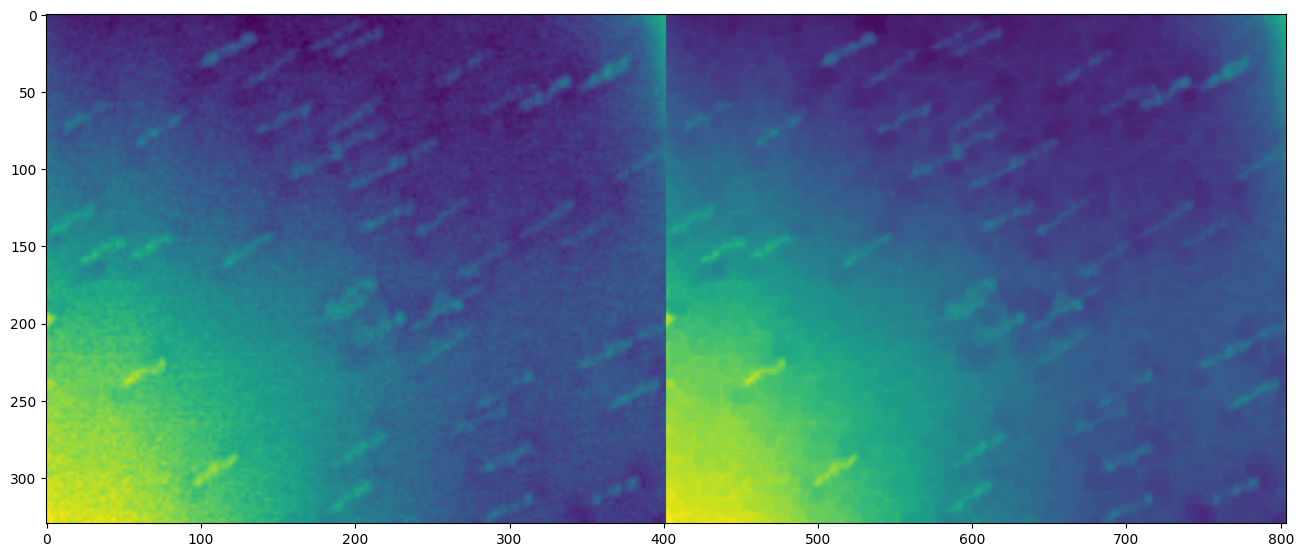

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2
mpl.rcParams['figure.figsize'] = [16,8]

readthese = 'C:/Users/kelle/Paleo/Thesis/Pictures/iona_nolabel.png'    

image = cv2.imread(readthese)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
'Dilation'
kernel = np.ones((5,5), np.uint8)
# blurred = cv2.dilate(gray, kernel, iterations=1)
'opening'
# blurred = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
'closing'
blurred = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
'Gaussian blur'
# blurred = cv2.GaussianBlur(blurred, (3, 3), 0)

plt.imshow(np.hstack([gray, blurred]))

params: [  2.03187251 -20.41832669]
error = [ 0.0498008  12.84725442]


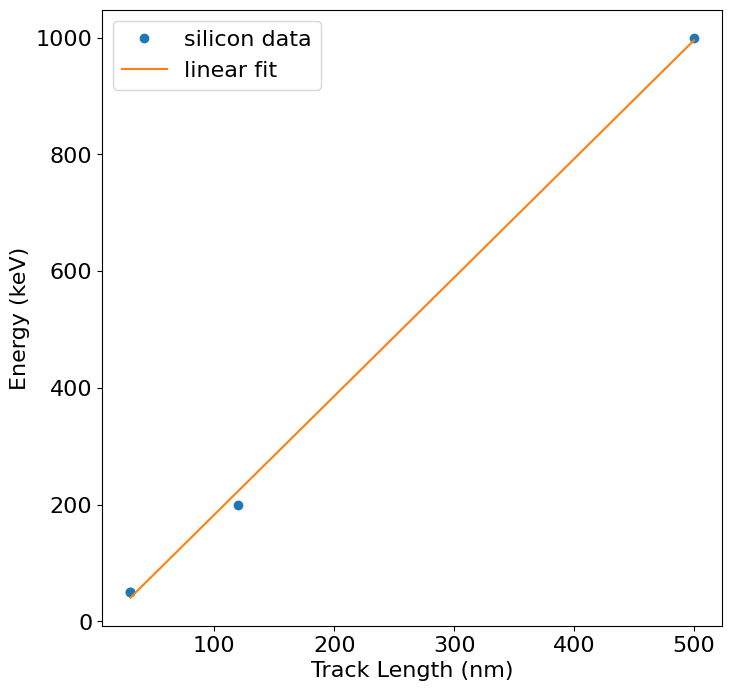

params: [ 1.00477006e+00 -1.54967996e+03 -1.59194926e+03  2.04116080e-01]
error = [inf inf inf inf]


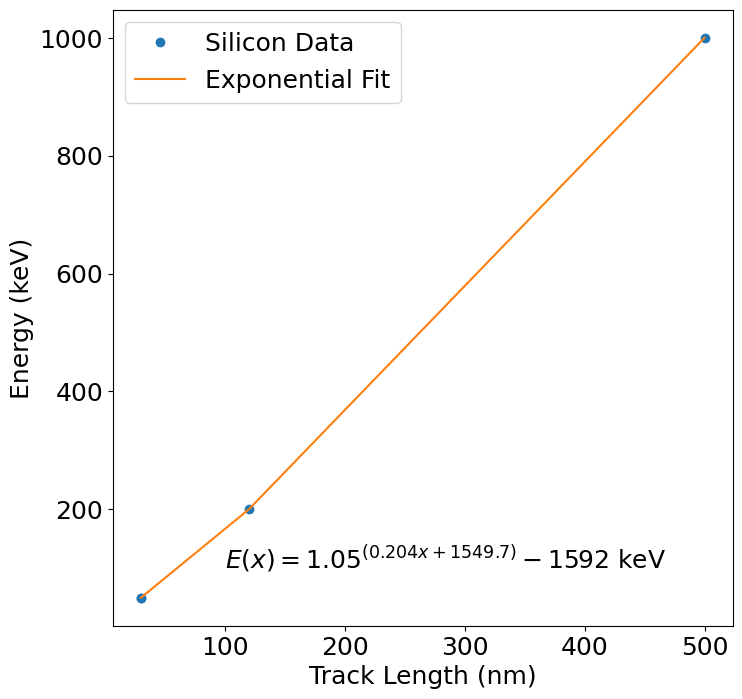

2.8440566724118526


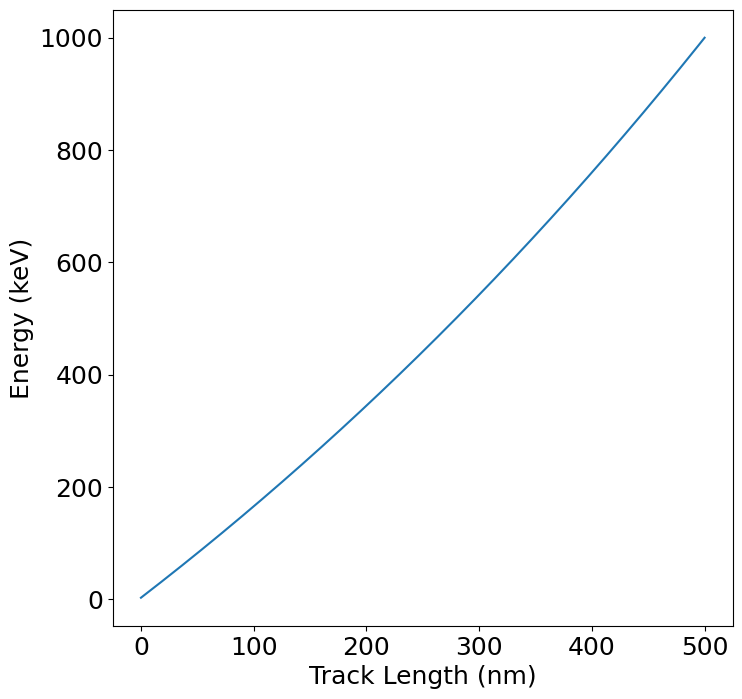

In [10]:
from scipy.optimize import curve_fit

# modeling of track length to energy for silicon
tlengths = np.array([30,30,120,500])#,30,30,120,500]) # in nm
energies = np.array([50,50,200,1000])#,50,50,200,1000]) # in keV

def linear(x,m,b):
    return m*x+b

vals, cov = curve_fit(linear, tlengths, energies)

print('params:', vals)
print('error =', np.sqrt(np.diag(cov)))

plt.plot(tlengths, energies, 'o', label='silicon data')
plt.plot(tlengths, linear(tlengths,vals[0],vals[1]), label='linear fit')
plt.xlabel('Track Length (nm)')
plt.ylabel('Energy (keV)')
plt.legend()
plt.show()

def expo(x,a,b,c,d):
    return a**(d*x-b)+c

vals, cov = curve_fit(expo, tlengths, energies)

print('params:', vals)
print('error =', np.sqrt(np.diag(cov)))

plt.rcParams.update({'font.size':18})
plt.figure(figsize=(8,8))
plt.plot(tlengths, energies, 'o', label='Silicon Data')
plt.plot(tlengths, expo(tlengths,vals[0],vals[1],vals[2],vals[3]), label='Exponential Fit')
plt.text(100,100,r"$E(x)=1.05^{(0.204x+1549.7)}-1592$ keV")
plt.xlabel('Track Length (nm)')
plt.ylabel('Energy (keV)')
plt.legend()
plt.show()

fullDist = np.arange(0,500,0.001)
fullEng = expo(fullDist, vals[0],vals[1],vals[2],vals[3])

print(fullEng[0])

plt.plot(fullDist, fullEng)
plt.xlabel('Track Length (nm)')
plt.ylabel('Energy (keV)')
plt.show()

(6, 1)
(132660, 1)


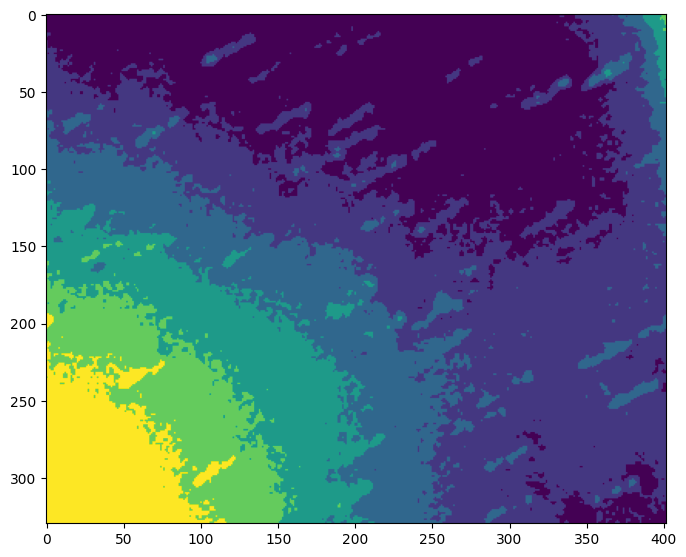

In [16]:
# k means clustering attempt
img = cv2.imread('C:/Users/kelle/Paleo/Thesis/Pictures/iona_nolabel.png' )
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
pix = img.reshape((-1,1))
pix = np.float32(pix)
# print(pix.shape)

# stop when 100  iterations exceeded or clusters move less than 0.2
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0)

k = 6
_, labels, (centers) = cv2.kmeans(pix, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)
print(centers.shape)
print(labels.shape)

segment = centers[labels.flatten()]
segment = segment.reshape((img.shape))
plt.imshow(segment)

In [ ]:
# contour sorting!

# sorts contours based on x or y position (top->bottom or left->right, or vice versa)
def sortContours(cnts, method='left-to-right'):
    reverse = False; i = 0
    if method == 'right-to-left' or method == 'bottom-to-top':
        method = True
    if method == 'top-to-bottom' or method == 'left-to-right':
        # sorting against y-coord rather than x-coord of bounding box
        i = 1
    
    # construct list of bounding boxes, sort from top to bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b:b[1][i], reverse=reverse))

    return (cnts, boundingBoxes)

# for sorting by area
sortcnts = sorted(cnts, key=cv2.contourArea, reverse=True)

def labeledDraw(image, cnt, i):
    # get centre of contour
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

    # draw contour on image
    cv2.putText(image, '#{}'.format(i+1), (cx,cy), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), 1)

    return image